---
title: "7. Merton Model Real Data"
author: "Jordan Chong"
date: "2024-02-22"
format:
  html:
    theme: lux          # A clean, professional quantitative theme
    toc: true           # Adds a table of contents on the right
    toc-depth: 3
    number-sections: true
    code-fold: show     # Allows viewers to collapse/expand your Python code!
    code-tools: true
    df-print: paged     # Makes pandas DataFrames look beautiful
execute:
  warning: false        # Hides Python warnings from the final HTML
  echo: true            # Shows your code (crucial for a portfolio)
---

## Setup: Importing and Defining the State

In [5]:
import numpy as np
import warnings
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. Import your tools
from data_loader import MarketDataLoader
from quant_math_engine import merton_jump_call, implied_volatility # Change this import for Heston/Bates

# 2. Load the data
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

# 3. Calculate target IVs for the optimizer
target_ivs = []
valid_strikes = []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs)
print(f"✅ Ready! Targeting {len(valid_strikes)} liquid strikes.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Ready! Targeting 352 liquid strikes.


## Calibration of the Merton-Jump Model

In [6]:
# --- MERTON OBJECTIVE FUNCTION ---
def merton_objective(params):
    sigma, lam, mu_j, delta = params
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            # Notice how clean this is because the math is hidden in your engine!
            m_price = merton_jump_call(S0, K, T, r, q, sigma, lam, mu_j, delta)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv): error += 5.0
            else: error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# --- RUN OPTIMIZER ---
merton_guess = [0.15, 1.0, -0.15, 0.10] 
merton_bounds = [(0.05, 0.30), (0.1, 5.0), (-0.5, 0.0), (0.01, 0.30)]

print("Optimizing Merton Parameters...")
start_time = time.time()
res_merton = minimize(merton_objective, merton_guess, method='L-BFGS-B', bounds=merton_bounds)

print(f"✅ Finished in {round(time.time() - start_time, 2)}s")
print(f"Parameters: {res_merton.x}")

Optimizing Merton Parameters...
✅ Finished in 62.25s
Parameters: [ 0.08582077  0.99228655 -0.0824808   0.07785328]


## Visualising the Model against Live Data

Generating Volatility Smile...


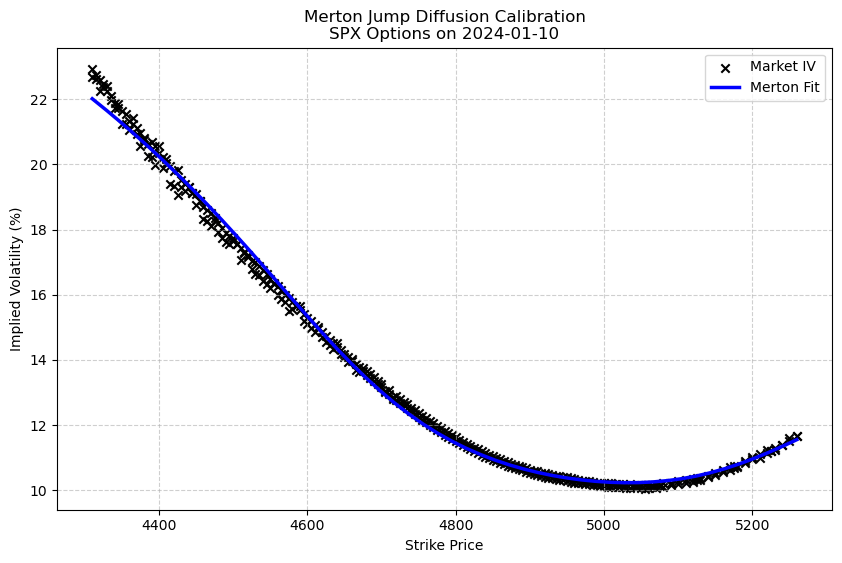

In [7]:
print("Generating Volatility Smile...")

smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
merton_prices = [merton_jump_call(S0, k, T, r, q, *res_merton.x) for k in smooth_strikes]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    merton_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(merton_prices, smooth_strikes)]

valid_idx = ~np.isnan(merton_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(merton_iv)[valid_idx] * 100

plt.figure(figsize=(10, 6))
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x')
plt.plot(clean_strikes, clean_iv, color='blue', label='Merton Fit', linewidth=2.5)

plt.title(f"Merton Jump Diffusion Calibration\nSPX Options on {TARGET_DATE}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()